In [5]:
%pylab inline
import torch
import torch.nn as nn

def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

Populating the interactive namespace from numpy and matplotlib


In [6]:
!pip install torch

# ACSE Module 8 - Practical - Morning Session 2:
----
# Pytorch, Automatic Differentiation, Optimization



[Pytorch](https://www.pytorch.org) is a (almost) drop-in replacement to numpy functionality but with added automatic differentiation capabilities.  

## Awesome [Pytorch](https://www.pytorch.org) functionalities and where to find them:

- [torch.Tensor](https://pytorch.org/docs/stable/tensors.html): Fundamental Tensor operations (matmul, sum, mean, transpose, ...)
- [torch.nn](https://pytorch.org/docs/stable/nn.html): Specialised functions for implementing (deep) neural networks
    - [torch.nn.DataParallel](https://pytorch.org/docs/stable/nn.html#dataparallel-layers-multi-gpu-distributed): Parallel and Distributed Computing
    - [Activation Functions](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity): Sigmoid, Tanh, ReLU, ...
    - [Linear Layers](https://pytorch.org/docs/stable/nn.html#linear-layers)
    - [Convolutional Layers](https://pytorch.org/docs/stable/nn.html#convolution-layers)
    - [Loss Functions](https://pytorch.org/docs/stable/nn.html#loss-functions): MSE-Loss, CrossEntropyLoss, ...
- [torch.optim](https://pytorch.org/docs/stable/optim.html): First and Second-order Gradient Descent Optimizers
- [torch.autograd](https://pytorch.org/docs/stable/autograd.html): Automatic Differentiation Functionality
- [torch.distributions](https://pytorch.org/docs/stable/distributions.html): Probability Distributions
- [torch.utils](): Utility functions
    - [torch.utils.data](https://pytorch.org/docs/stable/data.html): Contains useful methods to load and handle data
- [torchvision](https://pytorch.org/docs/stable/torchvision/index.html): Datasets, Pre-trained Models, Transforms

## Task 0: Basic Pytorch Tensor Operations 

### 0.1: Basic torch.Tensor operations.

In [7]:
#Setting the random seed of torch, numpy and python's random module
set_seed(42)

#Declare a scalar value
a = torch.Tensor(1)
print(a, a.item())

#Declare a tensor-like another tensor - creates tensor of the same shape
b = torch.zeros_like(a)
print(b, b.item())

#Create a torch.Tensor from a numpy array - doesn't copy memory! :)
c = torch.from_numpy(np.array(range(42))) 
print(c)

#Get back the underlying numpy array
print(c.numpy())

tensor([7.3787e+22]) 7.378699881283634e+22
tensor([0.]) 0.0
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41])
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41]


### 0.2: Basic torch.Tensor operations.

In [8]:
#Create a tensor of Gaussian (0-mean, 1-std. dev.) values
m = torch.randn(1, 1, 28, 28)
print(m.size())

torch.Size([1, 1, 28, 28])


### 0.3: Plotting Pytorch Tensors

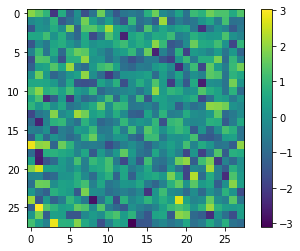

In [9]:
plt.imshow(m[0, 0])
plt.colorbar()

### 0.3: Using a GPU
We can also make use of a GPU (if we have one) by specifying ```.cuda()``` on any Tensors and later Modules.

In [10]:
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")
    
#Move tensors around using the .to(device) command
tensor_on_device = torch.ones(1).to(device)
print(tensor_on_device.device)

No GPU available!
cpu


### 0.4: Pytorch Autograd with simple functions

Pytorch allows us to write pythonic functions and use them in our computational graph.

In [11]:
a = torch.ones(1, requires_grad=True)*np.pi
def f(x):
    return torch.sin(x)
y = f(a)
print(a.item(), y.item())

# We can explicitly calculate gradients of a function with respect to a parameter or set of parameters:
print("The derivative is: ", torch.autograd.grad(y, a)[0].item())


3.1415927410125732 -8.742277657347586e-08
The derivative is:  -1.0


### 0.5: Pytorch Modules

We will make a simple parametric parabola as a Pytorch module.  
We don't need to write a backward (derivative) for pytorch modules as long as we use pytorch functionality only.

In [12]:
class ParametricParabola(nn.Module):
    def __init__(self, a, b):
        super().__init__()
        self.a = torch.nn.Parameter(torch.ones(1, requires_grad=True)*a)
        self.b = torch.nn.Parameter(torch.ones(1, requires_grad=True)*b)
    
    def forward(self, x):
        return self.a*x*x+self.b

Let's inspect what the parameters are:

In [13]:
f = ParametricParabola(0.5, 2)
print(f.a)
print(f.b)

Parameter containing:
tensor([0.5000], requires_grad=True)
Parameter containing:
tensor([2.], requires_grad=True)


We can also compute gradients for this example with respect to the parameters:

In [14]:
f.zero_grad() #this resets all the gradients within the computational graph.
x = torch.ones(1, requires_grad=False)*np.pi
y = f(x)
y.backward() #call autograd to compute all partial derivatives with respect to all Parameters that require gradients
print(f.a.grad, f.b.grad)

tensor([9.8696]) tensor([1.])


### 0.6 Using Pytorch's Optimization functionality

We can use methods from ```torch.optim``` to optimize parameters.  
We use this here to find the global minimum of our parabola with gradient descent.

In [15]:
set_seed(42)
x = torch.from_numpy(np.array([50])).float()
x.requires_grad = True
f = ParametricParabola(2., 0.)
optimizer = torch.optim.SGD([x], lr=1e-2)
for i in range(1000):
    optimizer.zero_grad()
    value = f(x)
    value.backward()
    optimizer.step()
    if i % 100 == 99:
        print("Iteration ", i, " Functional value: ", value.item())

Iteration  99  Functional value:  1.5440950393676758
Iteration  199  Functional value:  0.00043946102960035205
Iteration  299  Functional value:  1.250740098157621e-07
Iteration  399  Functional value:  3.559699757182955e-11
Iteration  499  Functional value:  1.0131178970025027e-14
Iteration  599  Functional value:  2.883410581065414e-18
Iteration  699  Functional value:  8.206407158350303e-22
Iteration  799  Functional value:  2.3356080922195324e-25
Iteration  899  Functional value:  6.647320721515809e-29
Iteration  999  Functional value:  1.8918796934005544e-32


## Task 1: Plotting the Ackley Function using Numpy

The [Ackley](https://en.wikipedia.org/wiki/Ackley_function) function is a common test problem for optimization problems with many local minima:
\begin{equation*}
f(x, y)= -20 exp [-0.2\sqrt{0.5(x^2+y^2)}]-exp[0.5\{cos(2 \pi x) + cos(2 \pi y)\}]+ e +20
\end{equation*}

In the following problem tasks we will use pytorch to evaluate this function numerically and study its behavior under common gradient descent techniques.

- 1.1: Define the Ackley-Function as a python method 
- 1.2: Use your previous defined method to plot the function in 3d in the range $(x, y)\in [-5, 5]$
- 1.3: Use your previous defined method Plot the function in 3d in the range $(x, y) \in [-32, 32]$
- 1.4: What do you observe about this function? Why do you think this function is a test problem for optimization?

### 1.1: Define the Ackley-Function as a python method 

In [31]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

def ackley(x, y):
    # Add your code here
    value = None
    
    return value

### 1.2: Use your previous defined method to plot the function in 3d in the range $(x, y)\in [-5, 5]$

AttributeError: 'NoneType' object has no attribute 'ndim'

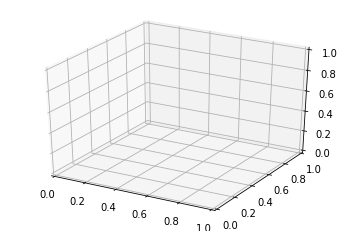

In [32]:
def plot_ackley_3d(x, y):
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    # Make data.
    x, y = np.meshgrid(x, y)
    
    z = ackley(x, y)

    # Plot the surface.
    surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                                   linewidth=0, antialiased=False)

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)

    plt.show()

x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
plot_ackley_3d(x, y)

### 1.3: Use your previous defined method Plot the function in 3d in the range $(x, y) \in [-32, 32]$

### 1.4: What do you observe about this function? Why do you think this function is a test problem for optimization?

## Task 2: The Ackley Function in Pytorch, Autograd and Gradient Descent

- 2.1: Define the Ackley-Function as a pytorch nn.Module class
- 2.2: Try to find the global minimum (solution: 0., 0.) of the Ackley function with Gradient Descent (```torch.optim.SGD```) from a random starting position. Use torch.randn to obtain a sample from a Gaussian.
    - Store and plot the corresponding function value as a function of the iteration number (ackley(x) vs. iteration)
    - Store and plot the norm of the gradients during optimization.
- 2.3: For 10 random starting positions (```torch.randn```) plot the Ackley function in 2D and the optimization trajectories together:
    - Do you reach a global minimum?
    - What do you observe for the various optimization trajectories.
    
### 2.1: Define the Ackley-Function as a pytorch nn.Module class

In [18]:
class Ackley(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, coords):
        value = None
        # Coords should have a shape of [N_Points x 2] (because of x and y coordinates)
        # Add your code here
        return value


### 2.2: Try to find the global minimum (solution: 0., 0.) of the Ackley function with Gradient Descent 

### 2.3: For 10 random starting positions (```torch.randn```) plot the Ackley function in 2D and the optimization trajectories together:

## Task 3: A Pytorch Module for Regression

Pytorch offers a number of modules pre-implemented, many of which we can use for basic and deep neural networks.  
Here we will use a simple linear module to perform linear regression of a dataset of points with Gaussian noise.

- 3.1: Use the provided pseudo-code to implement linear regression using gradient descent and pytorch's autograd functionality.

### 3.0: The provided linear regression dataset

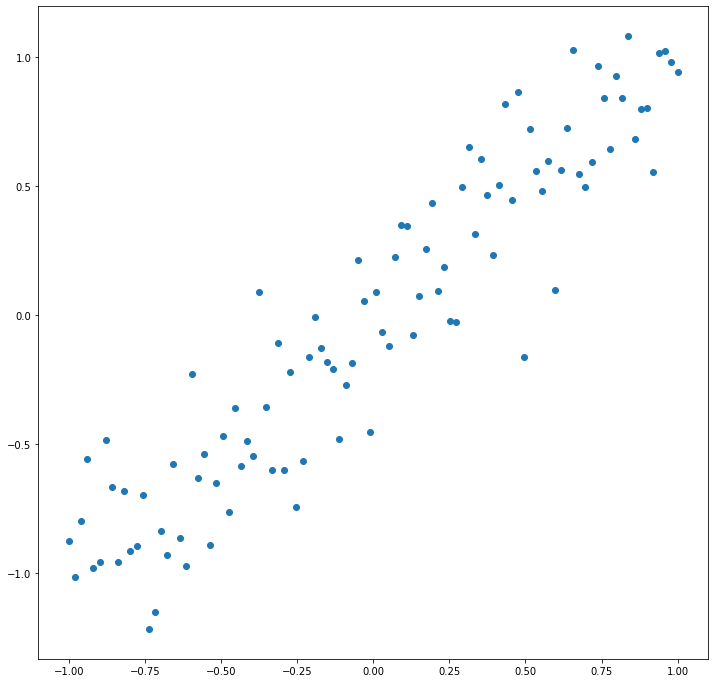

In [19]:
set_seed(42)
x = np.linspace(-1, 1, 100)
y = x + np.random.normal(0, 0.25, size=(100))

x, y = torch.from_numpy(x).float(), torch.from_numpy(y).float()

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.scatter(x, y)

### 3.1: Use the provided pseudo-code to implement linear regression using gradient descent and pytorch's autograd functionality.

In [20]:
model = nn.Linear(1, 1, bias=True)
print([(parameter, parameter.size())for parameter in model.parameters()])

optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss()
#Pseudo-Code
#iterate over the number of epochs (full data passes)
    #iterate over all the data points
        #reset optimizer gradients
        #predict for current data point the y value ~ model(x)
        #compute the loss by computing the criterion(y_prediction, y_ground_truth)
        #perform backpropagation
        #perform 1 optimizer step
        
#plot the regression line with the original data

[(Parameter containing:
tensor([[0.7645]], requires_grad=True), torch.Size([1, 1])), (Parameter containing:
tensor([0.8300], requires_grad=True), torch.Size([1]))]


## Definition of the half-moon dataset

In [21]:
import torch
from sklearn.datasets import make_moons
from sklearn.metrics import accuracy_score


def make_train_test(batch_size, batch_num, test_size, noise=0.05):
    """
    Makes a two-moon train-test dataset with fixed batch size, number and noise level
    """
    X_train, y_train = make_moons(n_samples=batch_size*batch_num, noise=noise)
    y_train = y_train.reshape(batch_num, batch_size, 1)
    X_train = X_train.reshape(batch_num, batch_size, 2)


    X_test, y_test = make_moons(noise=0.1)
    y_test = y_test.reshape(test_size, 1)
    return X_train, y_train, X_test, y_test

---
## Task 4: Backprop-From-Scratch using Numpy

In the following exercise you will implement a simple 1-Hidden Layer Neural Network from scratch using ```torch```.
We will use a simple toy dataset called the half-moon dataset as a training set.
To perform this task we will outline the necessary steps here and provide you with pseudo-code for your implementation.

1. Set the random number generator
2. Which hyper-parameters will you need to set prior to training?
3. Define the size of the input layer (D), the number of hidden layer units (H) and the output layer units (M).
    - Suggestion: use a small number of neurons in the hidden layer e.g. H=3
4. Define the training and test sets of your half-moon dataset.
5. We will use ```sigmoid``` activation functions. Define functions to compute the forward and "backward"-pass of the sigmoid. Your function should take in a ```torch.Tensor``` and return a ```torch.Tensor```
6. Define the weight tensors of each-layer. Initiallize the Weight-Tensors as ```torch.randn```. You should have two weight tensors W1, W2.
7. Within a training loop perform the following operations for the forward pass
    - Compute the affine layer transformation $z_1=W_1X$
    - Compute the non-linear activation $a_1=\sigma(z_1)$
    - Compute the affine layer transformation $z_2=W_2a_1$
    - Compute the non-linear activation $a_2=\sigma(z_2)$
    - Recall the chain-rule:
    - Compute the mismatch $\frac{\partial{L}}{\partial{a_2}}=(a_2-y)$
    - Compute the gradient of the Loss with respect to the weights of the output layer $\frac{\partial{L}}{\partial{W_2}}=a_1^T*\frac{\partial{L}}{\partial{a_2}}\frac{\partial{a_2}}{\partial{z_2}}$. You will need to use ```torch.transpose``` and ```torch.matmul``` to perform this operation.
    - Compute the error on the output of the hidden-layer $\frac{\partial{L}}{\partial{a_1}}$
    - Compute the gradient of the loss with respect to the hidden-layer weights $W_1$. This is the same operation as for the output layer.
    - Bonus: Compute the sensitivity of the loss with respect to the input $\frac{\partial{L}}{\partial{X}}$
    - Perform a gradient descent step on the weights: $W_2^{t+1} = W_2^{t}-\frac{\alpha}{N}\frac{\partial{L}}{\partial{W_2}}$. (Hint: the division by $N$ is necessary due to the ```torch.matmul``` operation being an effective summation over all the input examples.
    - Compute the training loss as the binary cross entropy $BCE(y, a_2)=\frac{1}{N}\sum{y\cdot log(a_2)+(1-y)\cdot log(1-a_2)}$
8. Perform the above iteration over a number of epochs (full-passes through the training set and use full-batch learning)
8. After training, evaluate the performance on the test set by evaluating $y_{pred}=\sigma(W_2\sigma(W_1 X))$ and computing the accuracy using ```sklearn.metrics.accuracy_score```.
9. Plot the prediction on the training and the test set.
10. Bonus: Plot the sensitivity of the loss with respect to each datapoint in the input of the training set.

In [22]:
set_seed(42)

epochs = 1000 #Number of loops through whole dataset

batch_size = 1000 #Size of a single batch
batch_num = 1 #Use full batch training
test_size = 100 #Examples in test set

lr = 1.
I, H, O = 2, 3, 1 #Define input size (2), Size of Hidden Layer (4), Output size (1)

#Use Sklearn to create two-moons + noise
X_train, y_train, X_test, y_test = make_train_test(batch_size, batch_num, test_size, noise=0.2)

#Define Train Set in Pytorch
X = torch.from_numpy(X_train).float()[0] #Convert to torch tensor, single batch
y = torch.from_numpy(y_train).float()[0] #Convert to torch tensor, single batch

#Define Test Set in Pytorch
X_test = torch.from_numpy(X_test).float() #Convert to torch tensor, already single batch
y_test = torch.from_numpy(y_test).float() #Convert to torch tensor, already single batch

#Define Activation Functions and Derivatives
#Sigmoid Activation Function
#Derivative of Sigmoid Activation Function

#Define Neural Network Parameters
#Define the weight matrices

#Enter training loop
for i in range(epochs):
    N = X.size(0) #Number of input examples
    #Forward Pass Layer 1
    #Affine Layer Transformation z1 = W1*X+b1
    #Apply non-linear activation function a1 = sigmoid(z1)
    
    #Forward Pass Layer 2
    #Affine Layer Transformation z2 = W2*a1+b2
    #Apply non-linear activation function a2 = sigmoid(z2)

    #Backward Pass Layer 2
    #Compute Error on Output
    #Compute derivative of activation function (Sigmoid)
    
    #Compute gradient w.r.t. weights in layer 2       
    
    #Backward Pass Layer 1
    #Compute Error on Output of Layer 1
    #Compute derivative of activation function (Sigmoid)
    
    #Compute gradient w.r.t. weights in layer 2

    #Sensitivity w.r.t. Input
    #Compute gradient w.r.t. input X

    #Take a step in gradient direction on layer 1 weights

    #Take a step in gradient direction on layer 2 weights
 
    #Compute Average Binary-Crossentropy Loss
    if i % 100 == 0:
        print("Training Loss in epoch "+str(i)+": %1.2f" % train_loss.item())
        print("Training accuracy in epoch "+str(i)+": %1.2f" % accuracy_score(y, np.where(a2[:, 0].numpy()>0.5, 1, 0)),"\n")
        
#Do Forward Pass of Test Dataset
#Forward Pass Layer 1
#Affine Layer Transformation z1 = W1*X
#Apply non-linear activation function a1 = sigmoid(z1)

#Forward Pass Layer 2
#Affine Layer Transformation z2 = W2*a1
#Apply non-linear activation function a2 = sigmoid(z2)
#Compute Binary-Crossentropy Loss on the Test Set

print("End of Training -> Testing Phase: ")
print("Train Loss: %1.2f" % train_loss.item(), ", Test Loss: %1.2f" % test_loss.item())
print("Training accuracy in epoch "+str(i)+": %1.2f" % accuracy_score(y, np.where(a2[:, 0].numpy()>0.5, 1, 0)))
print("Test accuracy in epoch "+str(i)+": %1.2f" % accuracy_score(y_test, np.where(a_test[:, 0].numpy()>0.5, 1, 0)))      

NameError: name 'train_loss' is not defined

## Task 5: Training a Neural Network with Pytorch

We will now perform the exact same exercise but using Pytorch's autograd functionality. 
Just as in the first few exercises we can create modules that contain all our "layers" and "activations".  
Pytorch then allows us to automatically compute derivatives from the defined computational graph.  
Pytorch essentially remembers all the operations that were performed on a dataset, and if you set ```requires_grad=True``` it will compute a gradient with respect to that parameter once you call backward on it.  
Let's see how this works for our 1-hidden layer neural network.

Here is the general workflow:

- 5.1: Define a SingleHiddenLayer Network as a pytorch module
- 5.2: Define the cost function
- 5.3: Setup the training function
- 5.4: Setup a validation/testing function
- 5.5: Create a training/validation/testing split of your data
- 5.6: Iterate over your dataset (epoch) and train your network using the train() and validate() methods
- 5.7: Make Predictions on the training and test set and plot the results

In [23]:
from torch.utils.data import TensorDataset, DataLoader 

### 5.1: Define a SingleHiddenLayer Network as a pytorch module

In [24]:
class SingleHiddenLayerNetwork(nn.Module):
    def __init__(self, I, H, O):
        super(SingleHiddenLayerNetwork, self).__init__()
        self.hidden_1 = nn.Linear(I, H, bias=False)
        self.output = nn.Linear(H, O, bias=False)
        self.activation = nn.Sigmoid()
        
    def forward(self, X):
        z1 = self.hidden_1(X)
        a1 = self.activation(z1)
        z2 = self.output(a1)
        a2 = self.activation(z2)
        return a2

### 5.2: Define the cost function

In [25]:
def bce_loss(y, a2):
    return -1/y.size(0)*(y*a2.log()+(1-y)*(1-a2).log()).sum(0)

### 5.3: Setup the training function

In [26]:
def train(model, optimizer, data_loader):
    model.train()
    for X, y in data_loader:
        optimizer.zero_grad()
        a2 = model(X)
        loss = bce_loss(y, a2)
        loss.backward()
        optimizer.step()
    
    y_pred = np.where(a2[:, 0].detach().numpy()>0.5, 1, 0)
    accuracy = accuracy_score(y, y_pred)
    return loss, accuracy

### 5.4: Setup a validation/testing function

In [27]:
def evaluate(model, data_loader):
    model.eval()
    for X, y in data_loader:
        with torch.no_grad():
            a2 = model(X)
            loss = bce_loss(y, a2)
    y_pred = np.where(a2[:, 0].numpy()>0.5, 1, 0)
    accuracy = accuracy_score(y, y_pred)
    return loss, accuracy

### 5.5: Create a training/validation/testing split of your data

In [28]:
#Define the size of the input, hidden, and output layers
I, H, O = 2, 3, 1

#Use Sklearn to create two-moons + noise
X_train, y_train, X_test, y_test = make_train_test(batch_size, batch_num, test_size, noise=0.2)

#Define Train Set in Pytorch
X_train = torch.from_numpy(X_train).float()[0] #Convert to torch tensor, single batch
y_train = torch.from_numpy(y_train).float()[0] #Convert to torch tensor, single batch

train_dataset = TensorDataset(X_train, y_train)

#Define Test Set in Pytorch
X_test = torch.from_numpy(X_test).float() #Convert to torch tensor, already single batch
y_test = torch.from_numpy(y_test).float() #Convert to torch tensor, already single batch

test_dataset = TensorDataset(X_test, y_test)

#Use Pytorch's functionality to load data in batches. Here we use full-batch training again.
train_loader = DataLoader(train_dataset, batch_size=X_train.size(0), shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=X_test.size(0), shuffle=False)

### 5.6: Iterate over your dataset (epoch) and train your network using the train() and validate() methods

In [29]:
network = SingleHiddenLayerNetwork(I, H, O)
optim = torch.optim.SGD(network.parameters(), lr=1)
for i in range(1000):
    train_loss, train_accuracy = train(network, optim, train_loader)
    test_loss, test_accuracy = evaluate(network, test_loader)
    
    if i % 100 == 0:
        print("Training Loss in epoch "+str(i)+": %1.2f" % train_loss.item())
        print("Training accuracy in epoch "+str(i)+": %1.2f" % train_accuracy)
        print("Test Loss in epoch "+str(i)+": %1.2f" % test_loss.item())
        print("Test accuracy in epoch "+str(i)+": %1.2f" % test_accuracy, "\n")

Training Loss in epoch 0: 0.73
Training accuracy in epoch 0: 0.50
Test Loss in epoch 0: 0.71
Test accuracy in epoch 0: 0.50 

Training Loss in epoch 100: 0.32
Training accuracy in epoch 100: 0.86
Test Loss in epoch 100: 0.31
Test accuracy in epoch 100: 0.87 

Training Loss in epoch 200: 0.30
Training accuracy in epoch 200: 0.87
Test Loss in epoch 200: 0.28
Test accuracy in epoch 200: 0.87 

Training Loss in epoch 300: 0.30
Training accuracy in epoch 300: 0.87
Test Loss in epoch 300: 0.28
Test accuracy in epoch 300: 0.86 

Training Loss in epoch 400: 0.30
Training accuracy in epoch 400: 0.87
Test Loss in epoch 400: 0.28
Test accuracy in epoch 400: 0.86 

Training Loss in epoch 500: 0.30
Training accuracy in epoch 500: 0.87
Test Loss in epoch 500: 0.28
Test accuracy in epoch 500: 0.86 

Training Loss in epoch 600: 0.30
Training accuracy in epoch 600: 0.87
Test Loss in epoch 600: 0.28
Test accuracy in epoch 600: 0.86 

Training Loss in epoch 700: 0.30
Training accuracy in epoch 700: 0.87


### 5.7: Make Predictions on the training and test set and plot the results

Test set accuracy:  0.86


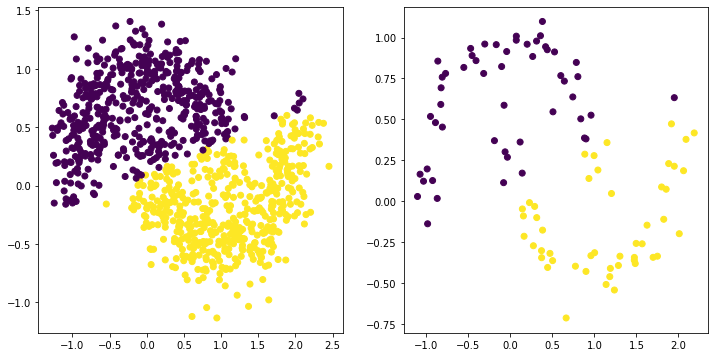

In [30]:
network.eval()
with torch.no_grad():
    a_train = network(X_train)
    a_test = network(X_test)
print("Test set accuracy: ", accuracy_score(y_test, np.where(a_test[:, 0].numpy()>0.5, 1, 0)))
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].scatter(X_train[:, 0], X_train[:, 1], c=np.where(a_train[:, 0].numpy()>0.5, 1, 0))
ax[1].scatter(X_test[:, 0], X_test[:, 1], c=np.where(a_test[:, 0].numpy()>0.5, 1, 0))

Looks almost the same as our own backprop results!